# Problem Statement : 
The dataset consists of 2-Dimensional spectrograms of radio signals from space collected at the SETI Institute by the Allen Telescope Array. The objective is to classify the radio signals from outer space into one of four classes.

Import Libraries

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Load and Pre-process the data

In [23]:
train_images = pd.read_csv("dataset/train/images.csv" , header = None)
train_labels = pd.read_csv("dataset/train/labels.csv" , header = None)

val_images = pd.read_csv("dataset/valid/images.csv" , header = None)
val_labels = pd.read_csv("dataset/valid/labels.csv" , header = None)

Input is train_images

In [24]:
# All the values in the image.csv are already normalised to lie in range 0 & 1
# No Column Names - These are all Pixel intensity values
train_images.head() 

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


Output/target is train_labels

0 - squiggle
1 - narrowband,
2 - narrowbanddrd
3 - noise

In [25]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


Check the shape of the training and validation data

In [26]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


8192 - (64*128)
Width of each image is 64
Height of each image is 128

Reshape the training and validation images

In [27]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

Visualize the dataset

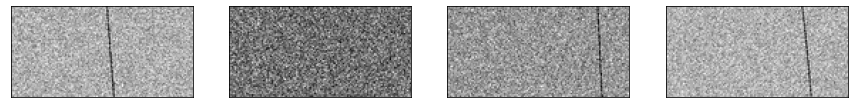

In [28]:
plt.figure(0, figsize=(15,15))
for i in range(1,5):
    plt.subplot(1,4,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

Create Training and Validation Data Generators using Keras ImageDataGenerator function

In [29]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip = True)
datagen_val.fit(x_val)

Design a Convolutional Neural Network (CNN) Model

In [30]:
# Initializing the Sequential Model
model = Sequential()

#1 st Convolution layer
model.add(Conv2D(32, (5,5), padding = 'same', input_shape = (64, 128, 1))) # '1' for greyscale Image
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))      # Since we are using the larger Number or Neurons
                             # Hence we are setting a higher Dropout Regularization rate

# Adding the last dense Output layer ->> SOFTMAX

model.add(Dense(4, activation = 'softmax')) # '4' as output has 4 classes

In [31]:
# Scheduling the Learning Rate
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 5,
    decay_rate = 0.96,
    staircase = True
)

# SettingUp the optimizer
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate = lr_schedule)

Compile the Model using Adam optimizer, categorical_crossentropy loss function, and accuracy metric

In [32]:
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Print the Model summary

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 64, 64)       

Train the Model with batch_size = 32 & epochs = 12

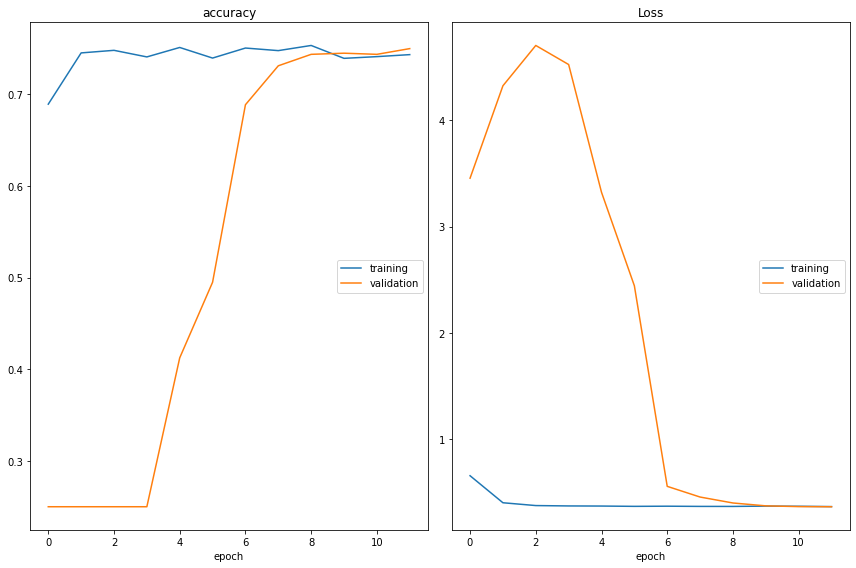

accuracy
	training         	 (min:    0.689, max:    0.753, cur:    0.743)
	validation       	 (min:    0.250, max:    0.750, cur:    0.750)
Loss
	training         	 (min:    0.369, max:    0.659, cur:    0.369)
	validation       	 (min:    0.368, max:    4.701, cur:    0.368)


In [34]:
from livelossplot.inputs.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint

# Creating the checkpoints i.e Saving the weights with maximum Validation accuracy
checkpoint = ModelCheckpoint("model_weights.h5",
                             monitor='val_loss',
                             save_weights_only=True,
                             mode='min',
                             verbose=0)

# Callbacks
callbacks = [PlotLossesCallback(), checkpoint]#, reduce_lr]

batch_size = 32

history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

Evaluate the Model

Use the model.evaluate function to evaluate the accuracy

In [35]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 5s 179ms/step - loss: 0.3671 - accuracy: 0.7462


[0.3670988380908966, 0.7462499737739563]

Print a Classification Report and the accuracy score (classification accuracy)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)

print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.3f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.50      0.88      0.64       200
           2       0.49      0.12      0.19       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.71       800
weighted avg       0.75      0.75      0.71       800

Classification accuracy: 0.746


Display a Confusion Matrix to evaluate the performance of the model

In [40]:
print('Confusion Matrix :')
tn,fp,fn,tp = confusion_matrix(y_true,y_pred)
print('TN : ',tn)
print('FP : ',fp)
print('FN : ',fn)
print('TP : ',tp)

Confusion Matrix :
TN :  [197   2   1   0]
FP :  [  0 176  24   0]
FN :  [  0 176  24   0]
TP :  [  0   0   0 200]


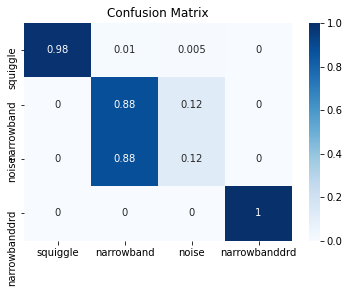

In [41]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); # annot = True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);